<a href="https://colab.research.google.com/github/seismomat/IBEM/blob/Lili/IBEM_SH_FUNCIONA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import scipy.special as scis
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt

In [2]:
#Función T22:
def T22(k,x,xi,normal):
    r= la.norm(x-xi)
    D = k*r * scis.hankel2(1,k*r)
    g_n=(x[0]-xi[0])/r * normal[0] + (x[1]-xi[1])/r * normal[1]
    return 1j/(4*r) * D * g_n

In [3]:
#Definición de parámetros del problema:
f = 0.5
w = 2*np.pi*f
beta = 0.3
lambd = beta/f
k = w / beta
rho = 0.3

# Ubicación de la Fuente
Fuente = np.array([1,-1])


In [4]:

#División de segmentos:
ns=4 #número de segmentos
segmento=np.zeros((ns+1,2))
segmento[:,0]=np.linspace(0,2,ns+1)

#Puntos medios:
dx=segmento[1,0]-segmento[0,0]

xp=np.zeros((ns,2))
xp[:,0]=segmento[:-1,0]+dx/2

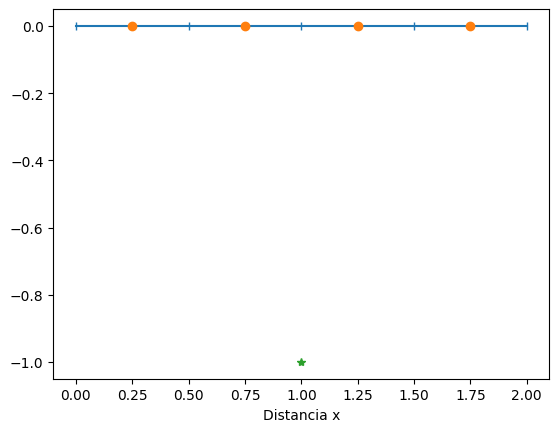

In [5]:
#Gráfica de geometría:

plt.plot(segmento[:,0],segmento[:,1],marker = '|')
plt.plot(xp[0:ns,0],xp[0:ns,1],'o')
plt.plot(Fuente[0],Fuente[1],marker = '*')

plt.xlabel('Distancia x')

plt.show()

In [6]:

#Vectores normales:
AB=segmento[1:]-segmento[:-1] #Diferencia
nor=AB[:,0] #Para obtener unitario
normal=AB*0 #Auxiliar
normal[:,0]=-AB[:,1]/nor
normal[:,1]=AB[:,0]/nor
print(normal)


[[-0.  1.]
 [-0.  1.]
 [-0.  1.]
 [-0.  1.]]


In [7]:
#Integración Gaussiana de T22
def Int_T22(n,l,k,segmento,xp,normal):
    #Para 5 puntos:
    nodos = [-0.906179845938664, -0.538469310105683,0, 0.538469310105683, 0.906179845938664]
    pesos = [0.236926885056189, 0.478628670499366, 0.568888888888889, 0.478628670499366, 0.236926885056189]

    #Para x
    b=segmento[l,0]
    a=segmento[l+1,0]
    xi_x_nodo = []  # Crear una lista vacía para almacenar los resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valo
      xi_x_nodo.append(resultado)

    #Para z
    b=segmento[l,1]
    a=segmento[l+1,1]
    xi_z_nodo = []
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xi_z_nodo.append(resultado)

    Xi_nodo = []  # Crear una lista vacía para almacenar las listas
    for i in range(len(nodos)):
      sublista = [xi_x_nodo[i], xi_z_nodo[i]]  # Crea la sublista
      Xi_nodo.append(sublista)  # Agrega la sublista a la lista

    Xi_nodo = np.array(Xi_nodo)

    L=la.norm(segmento[l]-segmento[n])
    Int=0.0
    for i in range(len(nodos)):
        Int += L/2 * pesos[i]*T22(k,xp[n],Xi_nodo[i],normal[n])
    return Int

El sistema que se va a hacer es:

\begin{equation}
  \begin{bmatrix}
    t_{22}(x_1,ξ_1) & t_{22}(x_1,ξ_2) & t_{22}(x_1,ξ_{3}) \\
    t_{22}(x_2,ξ_1) & t_{22}(x_2,ξ_2) & t_{22}(x_2,ξ_{3}) \\
    t_{22}(x_{3},ξ_1) & t_{22}(x_{3},ξ_2) & t_{22}(x_{3},ξ_{3})
  \end{bmatrix}
  \begin{bmatrix}
    ϕ_2(\xi_1) \\
    ϕ_2(\xi_2) \\
    ϕ_2(\xi_{3})
  \end{bmatrix}
  =
  \begin{bmatrix}
    -t_2^{(0)}(x_1) \\
    -t_2^{(0)}(x_2) \\
    -t_2^{(0)}(x_{3})
  \end{bmatrix}
\end{equation}

Cada $t_{22}$ se construye como:

\begin{equation}
  \int_{ξ-\frac{(x_2-x_1)}{2}}^{ξ+\frac{(x_2-x_1)}{2}} T_{22}(x,\xi)dS_ξ
\end{equation}

siendo $T_{22}$:

\begin{equation}
  T_{22}=\frac{i}{4r}D(kr) γ_k η_k
\end{equation}

In [8]:
#Construcción de matriz de tracciones:
M22=np.zeros([ns,ns])
M22 = M22 + 0j*M22

for n in range(ns):
    for l in range(ns):
        if n==l:
            M22[n,l]=0.5+0j
        else:
            M22[n,l]=Int_T22(n,l,k,segmento,xp,normal)

print(M22)

[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]


Calculo de $t_2^{(0)}$:

\begin{equation}
  T_{22}(x_1,x_R)
\end{equation}

El vector queda como:

\begin{equation}
  \begin{bmatrix}
    -T_{22}(x_1,x_R) \\
    -T_{22}(x_2,x_R) \\
    -T_{22}(x_{3},x_R)
  \end{bmatrix}
\end{equation}

In [9]:
#Fuente
t2=np.zeros([ns,1])
t2 = t2 + 0j*t2
for l in range(ns):
    t2[l]=-T22(k, xp[l], Fuente, normal[l])

print(t2)

[[ 0.4498643 +0.10686364j]
 [-0.50327056+0.35830396j]
 [-0.50327056+0.35830396j]
 [ 0.4498643 +0.10686364j]]


In [10]:
#Resolviendo el sistema:
solucion = np.linalg.solve(M22,t2)
print(solucion)

[[ 0.89972861+0.21372728j]
 [-1.00654111+0.71660791j]
 [-1.00654111+0.71660791j]
 [ 0.89972861+0.21372728j]]


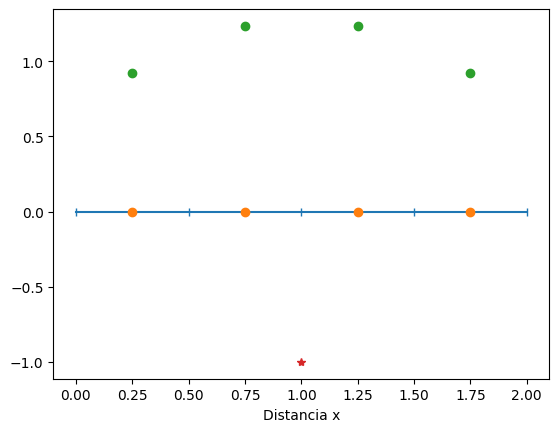

In [11]:
plt.plot(segmento[:,0],segmento[:,1],marker = '|')
plt.plot(xp[0:ns,0],xp[0:ns,1],'o')
plt.plot(xp[0:ns,0],np.abs(solucion),'o')
plt.plot(1,-1,marker = '*')

plt.xlabel('Distancia x')

plt.show()

In [12]:
#Desplazamientos:

